In [1]:
%reset -f

In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

import numpy as np
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')           ## CPU is faster here !

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='ticks',
        font='sans-serif', font_scale=1, color_codes=True, rc={"lines.linewidth": 2})

from updec.operators import *
from updec.utils import print_line_by_line, polyharmonic, multiquadric

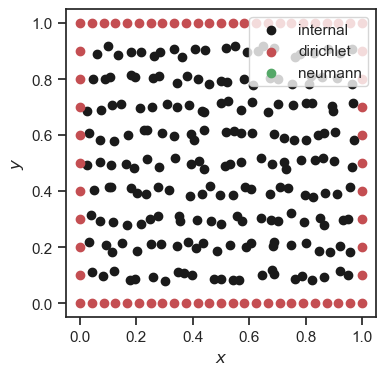

In [3]:
RBF = polyharmonic      ## Can define which rbf to use
MAX_DEGREE = 4

facet_types={0:"d", 1:"d", 2:"d", 3:"d"}
cloud = Cloud(Nx=25, Ny=11, facet_types=facet_types, noise_seed=35, support_size=1*11-1)
cloud.visualize_cloud(figsize=(4,4));

In [4]:
print("\n=== Meshfree cloud for RBF method ===\n")
print()
print("Cloud bounding box: Nx =", cloud.Nx, " -  Ny =", cloud.Ny)
print()
print("Boundary types (0=internal, 1=dirichlet, 2=neumann):\n", cloud.node_boundary_types)
print("Number of: \n\t-Internal points: Ni =", cloud.Ni, "\n\t-Dirichlet points: Md =", cloud.Nd, "\n\t-Neumann points: Mn =", cloud.Nn)
print("Surface types:\n", cloud.facet_types)
print()
print("Global indices:\n", cloud.global_indices)
print()
# # print("Global indices reversed:\n", cloud.global_indices_rev)
# # print()
# print("Outward normals on Neumann boundaries:")
# print_line_by_line(cloud.outward_normals)
# print()
# print("Node coordinates:", )
# print_line_by_line(cloud.nodes)
# print()
# print("Local supports (closest neighbours):")
# print_line_by_line(cloud.local_supports)


=== Meshfree cloud for RBF method ===


Cloud bounding box: Nx = 25  -  Ny = 11

Boundary types (0=internal, 1=dirichlet, 2=neumann):
 {207: 'd', 208: 'd', 209: 'd', 210: 'd', 211: 'd', 212: 'd', 213: 'd', 214: 'd', 215: 'd', 216: 'd', 217: 'd', 218: 'd', 0: 'i', 1: 'i', 2: 'i', 3: 'i', 4: 'i', 5: 'i', 6: 'i', 7: 'i', 8: 'i', 219: 'd', 220: 'd', 9: 'i', 10: 'i', 11: 'i', 12: 'i', 13: 'i', 14: 'i', 15: 'i', 16: 'i', 17: 'i', 221: 'd', 222: 'd', 18: 'i', 19: 'i', 20: 'i', 21: 'i', 22: 'i', 23: 'i', 24: 'i', 25: 'i', 26: 'i', 223: 'd', 224: 'd', 27: 'i', 28: 'i', 29: 'i', 30: 'i', 31: 'i', 32: 'i', 33: 'i', 34: 'i', 35: 'i', 225: 'd', 226: 'd', 36: 'i', 37: 'i', 38: 'i', 39: 'i', 40: 'i', 41: 'i', 42: 'i', 43: 'i', 44: 'i', 227: 'd', 228: 'd', 45: 'i', 46: 'i', 47: 'i', 48: 'i', 49: 'i', 50: 'i', 51: 'i', 52: 'i', 53: 'i', 229: 'd', 230: 'd', 54: 'i', 55: 'i', 56: 'i', 57: 'i', 58: 'i', 59: 'i', 60: 'i', 61: 'i', 62: 'i', 231: 'd', 232: 'd', 63: 'i', 64: 'i', 65: 'i', 66: 'i', 67: 'i', 6

In [5]:
## Operates on radial basis functions and polynomials at position x: don't forget the None. It is important!
# @jax.jit
# @partial(jax.jit, static_argnums=2)
def my_diff_operator(x, node=None, monomial=None):
    return  -1 * nodal_laplacian(x, node, monomial, rbf=RBF)

known_field = jnp.ones((cloud.N, 2))
## Operates on entire fields at position x (inside node)
# @jax.jit
def my_rhs_operator(x):
    # return divergence(x, known_field, cloud, rbf=RBF, max_degree=2)
    # return 2.0
    return 0.0

# d_func = lambda node: 1.0
# n_func = lambda node: 1.0

d_north = lambda node: jnp.sin(jnp.pi * node[0])
d_zero = lambda node: 0.0

boundary_conditions = {0:d_zero, 1:d_zero, 2:d_north, 3:d_zero}

In [6]:
solution_field = pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE)
# unknown_field

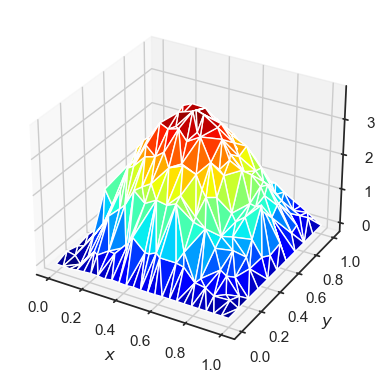

In [7]:
cloud.visualize_field(solution_field, cmap="jet", projection="3d", ax=None, figsize=(10,10));

TypeError: Input z must be 2D, not 1D

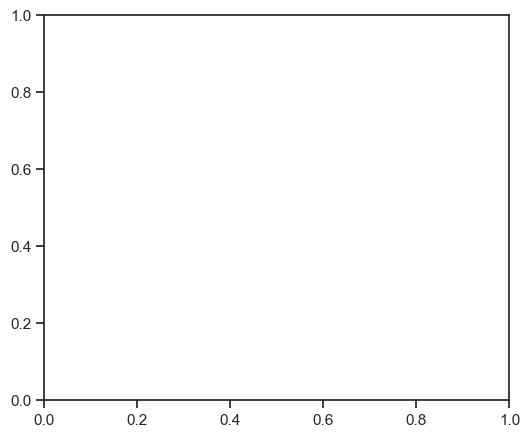

In [8]:
## Exact solution
sorted_nodes = sorted(cloud.nodes.items(), key=lambda x:x[0])
coords = jnp.stack(list(dict(sorted_nodes).values()), axis=-1).T

# exact_sol = jnp.zeros((cloud.N), dtype=jnp.float32)
def laplace_exact_sol(coord):
    return jnp.cos(jnp.pi*coord[0])*jnp.sinh(jnp.pi*coord[1])

laplace_exact_sol = jax.vmap(laplace_exact_sol, in_axes=(0,), out_axes=0)

exact_sol = laplace_exact_sol(coords)

# cloud.visualize_field(exact_sol, cmap="jet", projection="3d", ax=None, figsize=(10,10));
cloud.visualize_field(exact_sol, cmap="jet", projection="2d", ax=None, figsize=(6,5), bins=500, gridsize=100);

## Code profiling

In [ ]:
# ### Profiling the code
# import cProfile
# cloud = Cloud(Nx=11, Ny=7, facet_types=facet_types, noise_seed=34)
# cProfile.run('pde_solver(my_diff_operator, my_rhs_operator, cloud, boundary_conditions, RBF, MAX_DEGREE)', filename=None, sort=2)